## Testing model at varying levels of dropout

I want to load my model and test how it performs on validation data and train data on varying levels of dropout.

In [2]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from datamodule import WikipediaDataModule

import os

num_cpus = os.cpu_count()
dm = WikipediaDataModule(
    document_model_name_or_path="roberta-base",
    profile_model_name_or_path="google/tapas-base",
    max_seq_length=128,
    dataset_name='wiki_bio',
    dataset_train_split='train[:1]', # not used
    dataset_val_split='val[:20%]',
    dataset_version='1.2.0',
    word_dropout_ratio=0.0,
    word_dropout_perc=0.0,
    num_workers=1,
    train_batch_size=64,
    eval_batch_size=64
)
dm.setup("fit")

Initializing WikipediaDataModule with num_workers = 1 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:1]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)


loading wiki_bio[1.2.0] split val[:20%]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-b98e3ae8bfedd5c6.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-7d07543b6205ca87.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-7440752484ad8676.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-2c6f94b0d2dcc153.arrow


In [3]:
from model import CoordinateAscentModel

# model that was trained at the link given above, gets >99% validation accuracy,
# and is trained with word dropout!

from model_cfg import model_paths_dict

checkpoint_path = model_paths_dict["model_5"]

model = CoordinateAscentModel.load_from_checkpoint(
    checkpoint_path,
    document_model_name_or_path="roberta-base",
    profile_model_name_or_path="google/tapas-base",
    learning_rate=1e-5,
    pretrained_profile_encoder=False,
    lr_scheduler_factor=0.5,
    lr_scheduler_patience=1,
    train_batch_size=1,
    num_workers=1,
    gradient_clip_val=10.0,
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 1e-05 and patience 1


In [4]:
import numpy as np
import torch
import tqdm

def precompute_profile_embeddings():
    model.profile_model.cuda()
    model.profile_model.eval()

    model.val_profile_embeddings = np.zeros((len(dm.val_dataset), model.profile_embedding_dim))
    for val_batch in tqdm.tqdm(dm.val_dataloader()[0], desc="Precomputing val embeddings", colour="green", leave=False):
        with torch.no_grad():
            profile_embeddings = model.forward_profile(batch=val_batch)
        model.val_profile_embeddings[val_batch["text_key_id"]] = profile_embeddings.cpu()
    model.val_profile_embeddings = torch.tensor(model.val_profile_embeddings, dtype=torch.float32)
    model.profile_model.train()

precompute_profile_embeddings()

In [8]:
model.profile_model.cuda()
model.document_model.cuda()
model.document_embed.cuda()
model.document_model.eval()
model.val_profile_embeddings = model.val_profile_embeddings.cuda()

In [ ]:
from torch.utils.data import DataLoader
from masking_tokenizing_dataset import MaskingTokenizingDataset

val_tokenizing_dataset = MaskingTokenizingDataset(
    dm.val_dataset,
    document_tokenizer=dm.document_tokenizer,
    profile_tokenizer=dm.profile_tokenizer,
    max_seq_length=dm.max_seq_length,
    word_dropout_ratio=0.0,
    word_dropout_perc=0.0,
    profile_row_dropout_perc=0.0,
    sample_spans=False,
    document_types=["document"],
    is_train_dataset=True
)

import tqdm

accs = {}
num_samples = 1000

for dropout_amount in np.arange(0.0, 1.0+.1, 0.1): # [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    num_correct = 0
    num_total = 0
    print(f'Testing with dropout at {dropout_amount*100}%')
    val_tokenizing_dataset.masking_span_sampler.word_dropout_perc = dropout_amount
    val_tokenizing_dataset.masking_span_sampler.word_dropout_ratio = 1.0
    dropout_dataloader = DataLoader(
        [val_tokenizing_dataset[i] for i in range(num_samples)],
        batch_size=128,
        num_workers=min(dm.num_workers, 8),
        shuffle=False
    )
    for batch in tqdm.tqdm(dropout_dataloader, leave=False):
        with torch.no_grad():
            val_emb = model.forward_document(batch=batch, document_type='document')
        pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)
        true_idxs = batch['text_key_id'].cuda()
        num_correct += (pred_idxs == true_idxs).sum().item()
        num_total += len(true_idxs)

    acc = num_correct / num_total
    print(acc)
    accs[dropout_amount] = acc

Testing with dropout at 0.0%


0.998
Testing with dropout at 10.0%


0.997
Testing with dropout at 20.0%


0.995
Testing with dropout at 30.000000000000004%


0.982
Testing with dropout at 40.0%


0.982
Testing with dropout at 50.0%


0.952
Testing with dropout at 60.00000000000001%


0.92
Testing with dropout at 70.0%


0.84
Testing with dropout at 80.0%


 50%|█████     | 4/8 [00:01<00:01,  3.28it/s]

In [28]:
import pandas as pd
df = pd.DataFrame.from_dict(accs, orient='index', columns=['accuracy'])
df.head()

,accuracy
0.0,0.998
0.1,0.997
0.2,0.995
0.3,0.982
0.4,0.982


(0.0, 1.1)

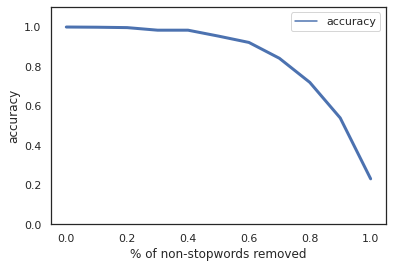

In [33]:
import seaborn as sns
sns.set()
sns.set_style("white")

ax = sns.lineplot(data=df, linewidth=3)
ax.set_xlabel("% of non-stopwords removed")
ax.set_ylabel("accuracy")
ax.set_ylim(bottom=0.0, top=1.1)

In [34]:
df.tail()

,accuracy
0.6,0.920
0.7,0.840
0.8,0.718
0.9,0.538
1.0,0.230


### What does 100% masking even look like?!

In [68]:
import random

print(val_tokenizing_dataset.masking_span_sampler.word_dropout_perc)

random_el = random.choice(dm.val_dataset)
random_document = random_el['document']
random_idx = random_el['text_key_id']

val_tokenizing_dataset.masking_span_sampler.random_redact_str(
    text=random_document
)

1.0


'<mask> <mask> is a <mask> <mask> <mask> <mask> <mask> , who was a <mask> of <mask> <mask> from <mask> to <mask> .\nshe was a <mask> <mask> on <mask> <mask>-<mask> <mask> <mask> for the <mask> <mask> from <mask> to <mask> .\nshe was an <mask> <mask> at the <mask> , <mask> and <mask> <mask> <mask> for the <mask> <mask> <mask> and was <mask> <mask> at the <mask> <mask> for the <mask> <mask> in <mask> .\nshe was <mask> by the <mask> , <mask> <mask> to <mask> <mask> on <mask> <mask> <mask> .\n<mask> was the <mask> <mask> <mask> <mask> for <mask> , <mask> <mask> , <mask> and <mask> .\nshe was a <mask> of the <mask> of the <mask> <mask> <mask> for <mask> , <mask> <mask> for the <mask> <mask> for the <mask> of the <mask> .\nshe is a <mask> of the <mask> <mask> of <mask> , <mask> <mask> <mask> , the <mask> <mask> <mask> for <mask> (<mask>) and the <mask> <mask> and <mask> <mask> .\n'

### OK no way model can get this right right?? How is that 23%? Something must be wrong??!

In [73]:
num_correct = 0
num_total = 0
print(f'Testing with dropout at {dropout_amount*100}%')
val_tokenizing_dataset.masking_span_sampler.word_dropout_perc = 1.0
val_tokenizing_dataset.masking_span_sampler.word_dropout_ratio = 1.0
dropout_dataloader = DataLoader(
    [val_tokenizing_dataset[i] for i in range(128)],
    batch_size=128,
    num_workers=min(dm.num_workers, 8),
    shuffle=False
)
for batch in tqdm.tqdm(dropout_dataloader, leave=False):
    with torch.no_grad():
        val_emb = model.forward_document(batch=batch, document_type='document')
    pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)
    true_idxs = batch['text_key_id'].cuda()
    num_correct += (pred_idxs == true_idxs).sum().item()
    num_total += len(true_idxs)

acc = num_correct / num_total

Testing with dropout at 100.0%


In [74]:
acc

0.25

In [78]:
batch['text_key_id'][true_idxs == pred_idxs]

tensor([  6,   9,  17,  21,  24,  26,  31,  33,  38,  39,  48,  52,  54,  55,
         59,  61,  66,  69,  71,  75,  84,  91,  93,  98,  99, 102, 114, 115,
        116, 118, 119, 127])

In [84]:
i = 6
doc = val_tokenizing_dataset.dataset[i]['document']
redacted_doc = val_tokenizing_dataset.masking_span_sampler.random_redact_str(text=doc)

In [85]:
redacted_doc

"<mask> <mask> <mask> (<mask> <mask> <mask> , <mask>) , <mask> `` the <mask> <mask> '' , is an <mask> <mask> <mask> <mask> <mask> with the <mask> <mask> <mask> of <mask> <mask> <mask> (<mask>) .\nhe <mask> and <mask> <mask>-<mask> .\n<mask> was <mask> by the <mask> <mask> <mask> <mask> in the <mask> <mask> (<mask> <mask>) of the <mask> <mask> <mask> <mask> <mask> .\nhe <mask> his <mask> <mask> <mask> in <mask> .\n<mask> has more <mask> (<mask>) than any other <mask> <mask> <mask> .\n"

In [87]:
tokenized_redacted_doc = val_tokenizing_dataset.document_tokenizer.encode_plus(
    redacted_doc,
    max_length=val_tokenizing_dataset.max_seq_length,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
)

In [91]:
with torch.no_grad():
    val_emb = model.forward_document_inputs(tokenized_redacted_doc)
    pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)

In [92]:
pred_idxs

tensor([6], device='cuda:0')

In [94]:
model.val_profile_embeddings.shape

torch.Size([14566, 768])

In [97]:
(val_emb @ model.val_profile_embeddings.T).max()

tensor(12.4562, device='cuda:0')

In [99]:
(val_emb @ model.val_profile_embeddings.T)[0, 6]

tensor(12.4562, device='cuda:0')

In [103]:
(-(val_emb @ model.val_profile_embeddings.T)).argsort()[0, :10].tolist()

[6, 2706, 8580, 11514, 6999, 13843, 14514, 4986, 2057, 13247]

In [104]:
(val_emb @ model.val_profile_embeddings.T)[0, 2706]

tensor(12.3210, device='cuda:0')

In [106]:
pd.read_csv('../adv_csvs/train/model_5/results_1_50.csv')['perturbed_text'].apply(lambda s: s.count('<mask>')).mean()

6.72

#### confirming model accuracy is 0 on adv-masked examples

In [9]:
import pandas as pd

pt = pd.read_csv('../adv_csvs/model_5/results_1_100.csv')['perturbed_text'].map(lambda s: s.replace('<SPLIT>', '\n'))

In [10]:
pt

0     pope <mask> iii <mask> alexandria (also known ...
1     <mask> <mask> is a male former <mask> tennis p...
2     <mask> <mask> (born 30 november <mask>) is a t...
3     <mask> <mask> , (born march 14 , <mask>) is a ...
4     <mask> <mask>. <mask> is a former democratic m...
                            ...                        
95    prince `` <mask> '' maria giuseppe carlo ignaz...
96    peter j. <mask> (<mask> 9 , 1849 -- october 1 ...
97    <mask> <mask> (born <mask> 15 , 1989 in regina...
98    <mask> <mask>. <mask> (january <mask> , 1917 -...
99    <mask> ` <mask> ' <mask> (born 21 <mask> <mask...
Name: perturbed_text, Length: 100, dtype: object

In [42]:
def get_model_predicted_idx(s: str) -> int:
    tokenized_doc = val_tokenizing_dataset.document_tokenizer.encode_plus(
        s,
        max_length=val_tokenizing_dataset.max_seq_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
    )
    with torch.no_grad():
        val_emb = model.forward_document_inputs(tokenized_doc)
        pred_idxs = (val_emb @ model.val_profile_embeddings.T).argmax(dim=1)
    return pred_idxs.item()

In [15]:
get_model_predicted_idx(val_tokenizing_dataset.dataset[300]['document'])

300

In [16]:
pt_idxs = pt.map(get_model_predicted_idx)
pt_idxs

0      6582
1     10388
2      2279
3      4726
4      3564
      ...  
95    14098
96    13388
97      335
98    12425
99     1872
Name: perturbed_text, Length: 100, dtype: int64

In [17]:
(pt_idxs == pt_idxs.index).sum()

2

In [18]:
pt[0]

'pope <mask> iii <mask> alexandria (also known as khail <mask>) was the <mask> pope of alexandria <mask> patriarch of the see of st. mark (880 -- <mask>) .\nin 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .\nthis building was at one time believed to have later become the site of the cairo geniza .\n'

In [130]:
val_tokenizing_dataset.dataset[6582]['name']

'Halil Hayreddin'

In [131]:
val_tokenizing_dataset.dataset[0]['document']

'pope michael iii of alexandria (also known as khail iii) was the coptic pope of alexandria and patriarch of the see of st. mark (880 -- 907) .\nin 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .\nthis building was at one time believed to have later become the site of the cairo geniza .\n'

In [132]:
get_model_predicted_idx('pope <mask> iii <mask> alexandria (also known as khail iii) was <mask> <mask> pope of <mask> <mask> patriarch of <mask> see of st. mark (880 -- <mask>) .\nin 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .\nthis building was at one time believed to have later become the site of the cairo geniza .\n')

6582

In [133]:
get_model_predicted_idx('pope michael iii of alexandria (also known as khail iii) was the coptic pope of alexandria and patriarch of the see of st. mark (880 -- 907) .\nin 882 , the governor of egypt , ahmad ibn tulun , forced khail to pay heavy contributions , forcing him to sell a church and some attached properties to the local jewish community .\nthis building was at one time believed to have later become the site of the cairo geniza .\n')

0

In [138]:
get_model_predicted_idx('pope <mask> <mask> of alexandria')

12746

In [139]:
val_tokenizing_dataset.dataset[12746]['name']

'Boniface V'

In [23]:
pd.read_csv('../adv_csvs/train/model_5/results_1_50.csv')['perturbed_text'].map(lambda s: s.count('<mask>')).mean()

6.72

### Comparing individual examples (adv masked and full dropout)

In [37]:
results = pd.read_csv('../adv_csvs/model_5/results_1_100.csv')

In [38]:
results['perturbed_text'][6]

"<mask> <mask> <mask> (<mask> <mask> <mask> , <mask>) , <mask> <mask> <mask> <mask> <mask> '' , <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> of major league <mask> (mlb) .<SPLIT>he bats and throws left-handed .<SPLIT><mask> was drafted by <mask> <mask> <mask> <mask> <mask> in the second round (52nd overall) of the 1999 major league baseball draft .<SPLIT>he made his major league debut in 2002 .<SPLIT><mask> has more <mask> (121) than any other active baseball player .<SPLIT>"

In [41]:
results['perturbed_text'][6].replace('<SPLIT>', '\n')

"<mask> <mask> <mask> (<mask> <mask> <mask> , <mask>) , <mask> <mask> <mask> <mask> <mask> '' , <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> of major league <mask> (mlb) .\nhe bats and throws left-handed .\n<mask> was drafted by <mask> <mask> <mask> <mask> <mask> in the second round (52nd overall) of the 1999 major league baseball draft .\nhe made his major league debut in 2002 .\n<mask> has more <mask> (121) than any other active baseball player .\n"

In [43]:
val_tokenizing_dataset.masking_span_sampler.word_dropout_perc = 1.0
val_tokenizing_dataset.masking_span_sampler.word_dropout_ratio = 1.0
val_tokenizing_dataset.masking_span_sampler.random_redact_str(
    text=results['original_text'][6].replace('<SPLIT>', '\n')
)

"<mask> <mask> <mask> (<mask> <mask> <mask> , <mask>) , <mask> `` the <mask> <mask> '' , is an <mask> <mask> <mask> <mask> <mask> with the <mask> <mask> <mask> of <mask> <mask> <mask> (<mask>) .\nhe <mask> and <mask> <mask>-<mask> .\n<mask> was <mask> by the <mask> <mask> <mask> <mask> in the <mask> <mask> (<mask> <mask>) of the <mask> <mask> <mask> <mask> <mask> .\nhe <mask> his <mask> <mask> <mask> in <mask> .\n<mask> has more <mask> (<mask>) than any other <mask> <mask> <mask> .\n"

In [44]:
# random dropout (100%)

get_model_predicted_idx("<mask> <mask> <mask> (<mask> <mask> <mask> , <mask>) , <mask> `` the <mask> <mask> '' , is an <mask> <mask> <mask> <mask> <mask> with the <mask> <mask> <mask> of <mask> <mask> <mask> (<mask>) .\nhe <mask> and <mask> <mask>-<mask> .\n<mask> was <mask> by the <mask> <mask> <mask> <mask> in the <mask> <mask> (<mask> <mask>) of the <mask> <mask> <mask> <mask> <mask> .\nhe <mask> his <mask> <mask> <mask> in <mask> .\n<mask> has more <mask> (<mask>) than any other <mask> <mask> <mask> .\n")

6

In [45]:
get_model_predicted_idx("<mask> <mask> <mask> (<mask> <mask> <mask> , <mask>) , <mask> <mask> <mask> <mask> <mask> '' , <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> of major league <mask> (mlb) .\nhe bats and throws left-handed .\n<mask> was drafted by <mask> <mask> <mask> <mask> <mask> in the second round (52nd overall) of the 1999 major league baseball draft .\nhe made his major league debut in 2002 .\n<mask> has more <mask> (121) than any other active baseball player .\n")

9080

In [55]:
[(i, val_tokenizing_dataset.dataset[i]['name']) for i in range(100)]

[(0, 'Michael Iii Of Alexandria'),
 (1, 'Hui Jun'),
 (2, 'Okan Öztürk'),
 (3, 'Marie Stephan'),
 (4, 'Leonard L. Martino'),
 (5, 'Salome Jens'),
 (6, 'Carl Crawford'),
 (7, 'Jim Bob'),
 (8, 'Riddick Parker'),
 (9, 'Blessed Osanna Of Cattaro -lrb- Ozana Kotorska -rrb-'),
 (10, 'Thaila Ayala'),
 (11, 'Sven Leuenberger'),
 (12, 'Brett Scott'),
 (13, 'Marlon Evans'),
 (14, 'Jesper Blicher'),
 (15, 'Stewart Ford'),
 (16, 'Chris Galletta'),
 (17, 'Barbara Coombs Lee'),
 (18, 'Darren M. Swain'),
 (19, 'Paul Quinn'),
 (20, 'Bob Motl'),
 (21, 'Christiane Soeder'),
 (22, 'Molwyn Joseph'),
 (23, 'Edmond Reusens'),
 (24, 'Nicetas'),
 (25, 'Kathy Stanton'),
 (26, 'Abby Elliott'),
 (27, 'Jeffrey Thomas'),
 (28, 'Paul Brooks -lrb- Cricketer -rrb-'),
 (29, 'Andreas Horvath'),
 (30, 'Asbjørn Kragh Andersen'),
 (31, 'Tigam'),
 (32, 'Dale Raoul'),
 (33, 'Ava Acres'),
 (34, 'Ernie Young'),
 (35, 'Samia Hamouda Abbou'),
 (36, 'Lotten Sjödén'),
 (37, 'Paul Stoll'),
 (38, 'Christine Isobel Mcgaffey Frederick

In [59]:
val_tokenizing_dataset.masking_span_sampler.word_dropout_perc = 1.0
val_tokenizing_dataset.masking_span_sampler.word_dropout_ratio = 1.0
get_model_predicted_idx(
    val_tokenizing_dataset.masking_span_sampler.random_redact_str(
        text=results['original_text'][98].replace('<SPLIT>', '\n')
    )
)

98

In [60]:
val_tokenizing_dataset.masking_span_sampler.random_redact_str(
        text=results['original_text'][98].replace('<SPLIT>', '\n')
    )

'<mask> a. <mask> (<mask> <mask> , <mask> -- <mask> <mask> , <mask>) was a <mask> <mask> <mask> <mask> and a <mask> .\nmost <mask> , he <mask> from <mask> to <mask> as <mask> <mask> of <mask> <mask> , from <mask> to <mask> as the <mask> <mask> <mask> to the <mask> <mask> and from <mask> to <mask> as <mask> to the <mask> <mask> of <mask> during the <mask> <mask> of <mask> <mask> .\n<mask> <mask> to the <mask> of <mask> <mask> in the <mask>.s. <mask> and is a <mask> of the <mask> <mask> <mask> of <mask> .\n'

In [61]:
results['perturbed_text'][98].replace('<SPLIT>', '\n')

'<mask> <mask>. <mask> (january <mask> , 1917 -- february 10 , 2002) was a united states army officer and a diplomat .\nmost notably , he served from 1972 to 1976 as deputy director of central intelligence , from 1985 to 1989 as the united states ambassador to the united nations and from 1989 to 1991 as ambassador to the federal republic of germany during the decisive phase of german reunification .\n<mask> rose to the rank of lieutenant general in the u.s. army and is a member of the military intelligence hall of fame .\n'

In [62]:
get_model_predicted_idx('<mask> a. <mask> (<mask> <mask> , <mask> -- <mask> <mask> , <mask>) was a <mask> <mask> <mask> <mask> and a <mask> .\nmost <mask> , he <mask> from <mask> to <mask> as <mask> <mask> of <mask> <mask> , from <mask> to <mask> as the <mask> <mask> <mask> to the <mask> <mask> and from <mask> to <mask> as <mask> to the <mask> <mask> of <mask> during the <mask> <mask> of <mask> <mask> .\n<mask> <mask> to the <mask> of <mask> <mask> in the <mask>.s. <mask> and is a <mask> of the <mask> <mask> <mask> of <mask> .\n')

98

In [63]:
get_model_predicted_idx('<mask> <mask>. <mask> (january <mask> , 1917 -- february 10 , 2002) was a united states army officer and a diplomat .\nmost notably , he served from 1972 to 1976 as deputy director of central intelligence , from 1985 to 1989 as the united states ambassador to the united nations and from 1989 to 1991 as ambassador to the federal republic of germany during the decisive phase of german reunification .\n<mask> rose to the rank of lieutenant general in the u.s. army and is a member of the military intelligence hall of fame .\n')

12425